In [1]:
import sys
import sys
sys.path.append("../")
import warnings
import src.soporte as sp
from fuzzywuzzy import fuzz
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
from datetime import datetime, time, timedelta
import folium
import geopy
from functools import partial 
import re
pd.options.display.max_columns = None

c:\Users\smico\anaconda3\envs\iron\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df = pd.read_csv('datos/volunteers_1v.csv', low_memory=False)
#Utilizamos low memory=False ya que al leerlo me daba un error porque en algunas columnas tienen diferentes tipos de datos, habrá que echarle un vistazo
df.head(5)

ParserError: Error tokenizing data. C error: Expected 1 fields in line 726, saw 3


In [ ]:
print(df.columns)

Index(['Course', 'Anglo Status', 'Date Modified', 'Age', 'Birth Date',
       'Veteran', 'Gender', 'Nationality ', 'Request Status',
       'Date Modified.1', 'Arrival Medium', 'Arrival Company',
       'Arrival Number', 'Name'],
      dtype='object')


In [ ]:
# Reemplaza los espacios por subrayados en los nombres de las columnas
df.columns= df.columns.str.lstrip()
df.columns= df.columns.str.rstrip()
df.columns = df.columns.str.replace(" ", "_")
df.head(2)

,Course,Anglo_Status,Date_Modified,Age,Birth_Date,Veteran,Gender,Nationality,Request_Status,Date_Modified.1,Arrival_Medium,Arrival_Company,Arrival_Number,Name
0,Zujar TEENS - 2 weeks - June/30/2019 to July/1...,Bad feedback,26/01/2022 13:21,20.0,NaN,Yes,Male,IRELAND,Cleared,27/02/2019 14:35,NaN,NaN,NaN,Andrew Rodriguez
1,Zujar TEENS - 2 weeks - June/30/2019 to July/1...,Approved,02/12/2019 10:21,21.0,NaN,Yes,Female,UNITED KINGDOM,Cleared,20/03/2019 12:47,NaN,NaN,NaN,Sarah Chavez


In [ ]:
df.shape

(91108, 14)

In [ ]:
df.isnull().sum()

Course                 0
Anglo_Status         744
Date_Modified        742
Age                  742
Birth_Date         90366
Veteran             4496
Gender                 0
Nationality            0
Request_Status       742
Date_Modified.1      742
Arrival_Medium     90927
Arrival_Company    90928
Arrival_Number     90995
Name                   0
dtype: int64

In [ ]:
#cambiamos los nulos de Anglo_Status a TBC y Veterano a "no"
df["Anglo_Status"].fillna("TBC", inplace=True)
df['Veteran'].fillna("No",inplace=True)


In [ ]:
#Queremos comprobar si todos los nulos de determinadas columnas están en las mismas filas
df_comparativa_nulos=df[['Date_Modified','Age','Request_Status','Date_Modified.1']]
#sumamos los nulos por filas, axis=1
filas_na = df_comparativa_nulos[['Date_Modified', 'Age', 'Request_Status','Date_Modified.1']].isnull().sum(axis=1)
#creamos una nueva variable que almacena las filas que cumplen con la condicion de que el numero de nulos por fila sea 4
coincide = filas_na[filas_na == 4]
print(f'Tenemos {coincide} filas que tienen 4 nulos, por lo cual es cierto que todos los nulos se situan en las mismas filas')

Tenemos 90366    4
90367    4
90368    4
90369    4
90370    4
        ..
91103    4
91104    4
91105    4
91106    4
91107    4
Length: 742, dtype: int64 filas que tienen 4 nulos, por lo cual es cierto que todos los nulos se situan en las mismas filas


In [ ]:
#Calculamos el porcentaje que representan los nulos
columnas_nulos = ['Date_Modified', 'Age', 'Request_Status', 'Date_Modified.1']
for col in columnas_nulos:
    porcentaje = sp.porcentaje_nulos(df,col) 
    print(f"El porcentaje de valores nulos en la columna '{col}' es: {porcentaje}%")

El porcentaje de valores nulos en la columna 'Date_Modified' es: 0.81%
El porcentaje de valores nulos en la columna 'Age' es: 0.81%
El porcentaje de valores nulos en la columna 'Request_Status' es: 0.81%
El porcentaje de valores nulos en la columna 'Date_Modified.1' es: 0.81%


In [ ]:
#Necesitamos una columna extra con los años en que los voluntarios han aplicado o asistido a los campamentos. La vamos a sacar del nombre de los curso
#Extraemos los años de la fecha de programa y lso añadimos a una columna nueva
df['Year'] = df['Course'].str.extract(r'(\d{4})')
#Calculamos el porcentaje de nulos en la nueva columna
porcentaje=sp.porcentaje_nulos(df,'Year')
print(f'El porcentaje de años nulos es de {porcentaje}%')

El porcentaje de años nulos es de 3.02%


In [ ]:
#Eliminamos los nulos, y lo almacenamos en un nuevo dataframe para mantener el dataframe original
df2=df.dropna(subset='Date_Modified')
nulos=df.shape[0]-df2.shape[0]
print(f'La diferencia entre el dataframe anterior y el nuevo es de {nulos}, que es el número de nulos que teniamos en las columnas analizadas')


La diferencia entre el dataframe anterior y el nuevo es de 742, que es el número de nulos que teniamos en las columnas analizadas


In [ ]:
#Creamos un nuevo dataframe con aquellos datos de llegada
df_arrivals=df[df['Arrival_Number'].isnull() == False]
df_arrivals.head(2)

,Course,Anglo_Status,Date_Modified,Age,Birth_Date,Veteran,Gender,Nationality,Request_Status,Date_Modified.1,Arrival_Medium,Arrival_Company,Arrival_Number,Name,Year
90367,La Alberca TEENS-VOLUNTEER 2 WEEKS from 07/02/...,TBC,NaN,NaN,17/06/2004,Yes,Male,USA,NaN,NaN,Plane,Delta Airlines,DL126,Dakota Mcconnell,2021
90373,La Alberca TEENS-VOLUNTEER 2 WEEKS from 07/09/...,TBC,NaN,NaN,10/10/2006,Yes,Female,USA,NaN,NaN,Plane,American Airlines,AA94,Rachel Johnson,2021


In [ ]:
#Eliminamos las columnas que tienen mayría de nulos para que el dataframe quede más legible
df2.drop(['Course','Arrival_Medium','Arrival_Company','Arrival_Number','Birth_Date'],axis=1,inplace=True)
df2 = df2.rename(columns={'Date_Modified.1': 'Date_Modified1'})
df2.head(2)

C:\Users\smico\AppData\Local\Temp\ipykernel_21336\2959943269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(['Course','Arrival_Medium','Arrival_Company','Arrival_Number','Birth_Date'],axis=1,inplace=True)


,Anglo_Status,Date_Modified,Age,Veteran,Gender,Nationality,Request_Status,Date_Modified1,Name,Year
0,Bad feedback,26/01/2022 13:21,20.0,Yes,Male,IRELAND,Cleared,27/02/2019 14:35,Andrew Rodriguez,2019
1,Approved,02/12/2019 10:21,21.0,Yes,Female,UNITED KINGDOM,Cleared,20/03/2019 12:47,Sarah Chavez,2019


In [ ]:
df2.isnull().sum()

Anglo_Status         0
Date_Modified        0
Age                  0
Veteran              0
Gender               0
Nationality          0
Request_Status       0
Date_Modified1       0
Name                 0
Year              2748
dtype: int64

In [ ]:
#Sustituimos los nulos por el valor siguiente
df2['Year'].fillna(method='ffill', inplace=True)
df2['Year'].isnull().sum()

0

Ya lo tenemos sin nulos, vamos a analizar la información.

In [ ]:
#Valores únicos
df2.apply(pd.Series.nunique)

Anglo_Status         17
Date_Modified     24768
Age                  86
Veteran               2
Gender                2
Nationality         188
Request_Status       18
Date_Modified1    41700
Name              26800
Year                 16
dtype: int64

In [ ]:
df2.to_csv("datos/aplicaciones.csv",index=False, header=True)

In [ ]:
warnings.filterwarnings("ignore")
#La primera vez que hemos corrido el código nos ha dado un error así que usamos la libreria Warnings
#Eliminamos los duplicados de la columna 'Name'
df_unicos = df2.drop_duplicates(subset='Name', inplace=False)
df_unicos.head(2)


,Anglo_Status,Date_Modified,Age,Veteran,Gender,Nationality,Request_Status,Date_Modified1,Name,Year
0,Bad feedback,26/01/2022 13:21,20.0,Yes,Male,IRELAND,Cleared,27/02/2019 14:35,Andrew Rodriguez,2019
1,Approved,02/12/2019 10:21,21.0,Yes,Female,UNITED KINGDOM,Cleared,20/03/2019 12:47,Sarah Chavez,2019


In [ ]:
df_unicos.drop(['Anglo_Status','Date_Modified','Request_Status','Date_Modified1'],axis=1,inplace=True)
df_unicos.head(2)

,Age,Veteran,Gender,Nationality,Name,Year
0,20.0,Yes,Male,IRELAND,Andrew Rodriguez,2019
1,21.0,Yes,Female,UNITED KINGDOM,Sarah Chavez,2019


In [ ]:
df_unicos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26800 entries, 0 to 90322
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          26800 non-null  float64
 1   Veteran      26800 non-null  object 
 2   Gender       26800 non-null  object 
 3   Nationality  26800 non-null  object 
 4   Name         26800 non-null  object 
 5   Year         26800 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.4+ MB


In [ ]:
df_unicos['Age'].astype(int)


0        20
1        21
2        20
3        21
4        23
         ..
90187    59
90257    30
90293    73
90313    53
90322    36
Name: Age, Length: 26800, dtype: int32

In [ ]:
df_unicos.to_csv("datos/voluntarios_unicos.csv",index=False, header=True)

In [ ]:
df_unicos.isnull().sum()

Age            0
Veteran        0
Gender         0
Nationality    0
Name           0
Year           0
dtype: int64

In [ ]:
#Hipotesis1: el mayor grupo de voluntarios pertenece al grupo de 41-60, tanto en aplicaciones como en voluntarios reales
#Vamos a crear dos dataframes, uno que solo contenga los veteranos y otro con todos pero solo las columnas necesarias, en los casos necesitamos que sean mayores de 18
#Seleccionamos aquellos que son mayores de 18
df_edad_reales = df_unicos[df_unicos['Age'] >= 18]
print(df_edad_reales['Age'].sort_values())
df_edad_totales=df2[df2['Age']>=18]
df_edad_totales.drop(['Anglo_Status','Date_Modified','Request_Status','Date_Modified1'],axis=1,inplace=True)
print(df_edad_totales['Age'].sort_values())


2936     18.0
55929    18.0
29       18.0
729      18.0
27       18.0
         ... 
47042    94.0
23473    94.0
67095    94.0
1715     98.0
52133    99.0
Name: Age, Length: 26770, dtype: float64
21223    18.0
108      18.0
4270     18.0
4272     18.0
53490    18.0
         ... 
87336    95.0
1752     98.0
1715     98.0
52801    99.0
52133    99.0
Name: Age, Length: 90307, dtype: float64


In [ ]:
#Creamos grupos de edad y los asignamos 
bins_age = [17, 25, 40, 60, 75, df['Age'].max()]
labels_age = ['18-25', '26-40', '41-60', '61-75', '76+']
df_edad_reales['Age_Group'] = pd.cut(df_edad_reales['Age'], bins=bins_age, labels=labels_age)
df_edad_totales['Age_Group'] = pd.cut(df_edad_totales['Age'], bins=bins_age, labels=labels_age)


In [ ]:
#Vamos a ver si se ha generado algun nulo en alguno de los campos
print(df_edad_reales.isna().sum())
print(df_edad_totales.isna().sum())


Age            0
Veteran        0
Gender         0
Nationality    0
Name           0
Year           0
Age_Group      0
dtype: int64
Age            0
Veteran        0
Gender         0
Nationality    0
Name           0
Year           0
Age_Group      0
dtype: int64


In [ ]:
mediana_age_reales=df_edad_reales['Age'].median()
mediana_age_totales=df_edad_totales['Age'].median()

In [ ]:
#La primera comprobacion será entre los grupos de edades por aplicaciones y reales. >Les separamos en dos dtaframes que usaremos para las gráficas
age_groups_real = df_edad_reales.groupby(['Age_Group']).size().reset_index(name='Total')
age_groups_total= df_edad_totales.groupby(['Age_Group']).size().reset_index(name='Total')


In [ ]:
#Llamamos a la función porcentaje que está guardada en soporte.py
age_groups_real['Porcentaje']=sp.porcentaje(age_groups_real,'Total')
age_groups_total['Porcentaje']=sp.porcentaje(age_groups_total,'Total')
print(age_groups_real)
print(age_groups_total)

  Age_Group  Total  Porcentaje
0     18-25   3207       11.98
1     26-40  12479       46.62
2     41-60   4995       18.66
3     61-75   4805       17.95
4       76+   1284        4.80
  Age_Group  Total  Porcentaje
0     18-25  10010       11.08
1     26-40  34833       38.57
2     41-60  17688       19.59
3     61-75  21231       23.51
4       76+   6545        7.25


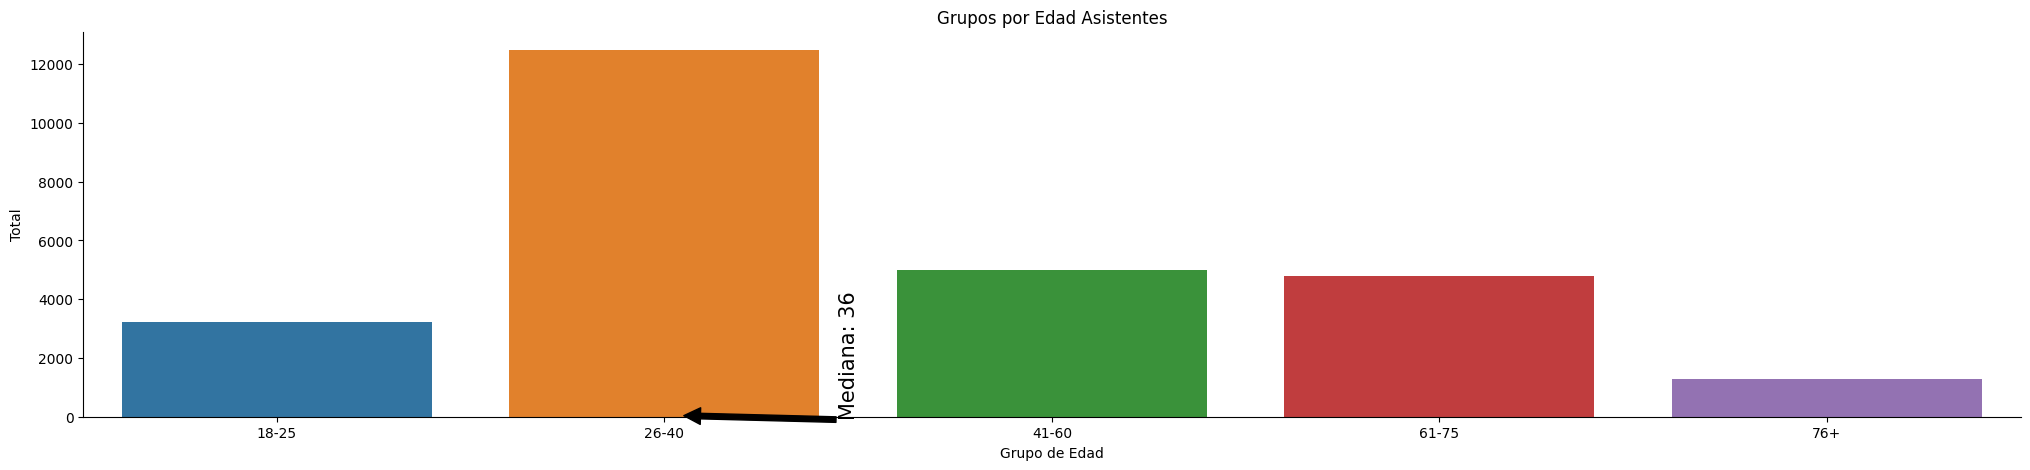

In [ ]:
sp.graf_barras(mediana_age_reales,'Age_Group', 'Total', age_groups_real,'Grupo de Edad', 'Total','Grupos por Edad Asistentes')


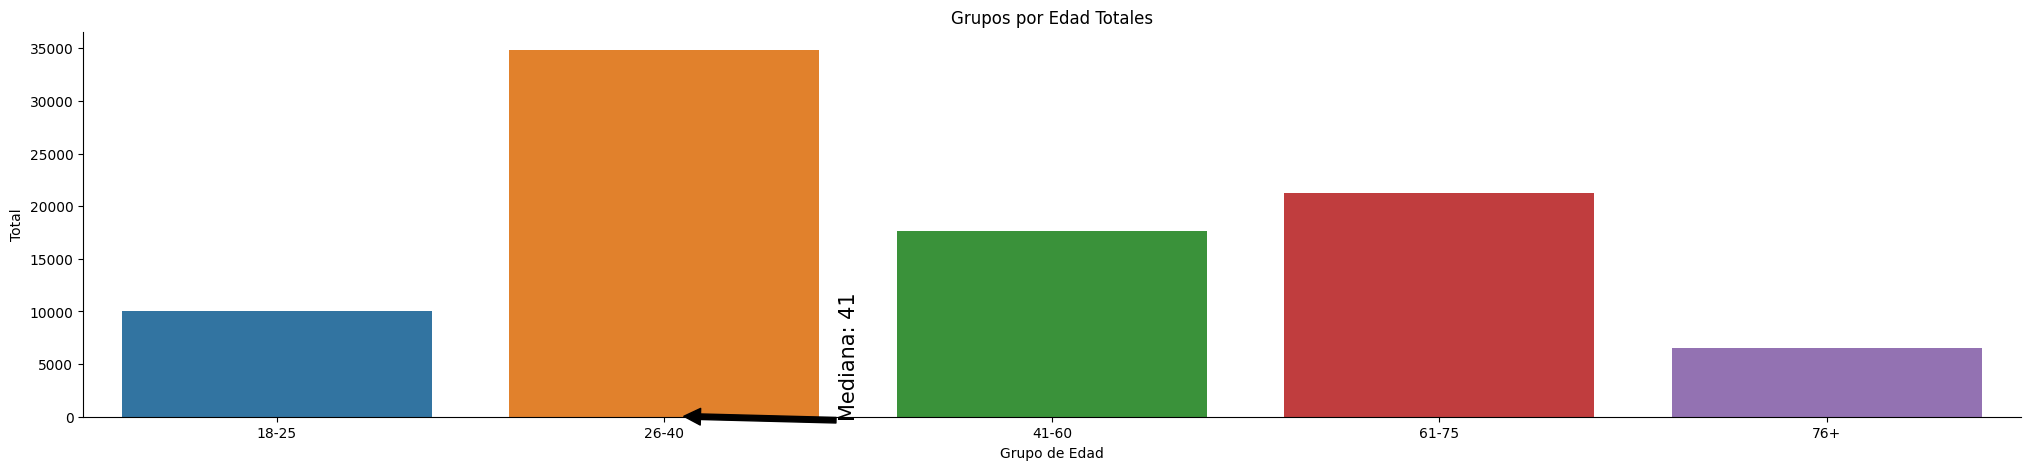

In [ ]:
sp.graf_barras(mediana_age_totales,'Age_Group', 'Total', age_groups_total,'Grupo de Edad', 'Total','Grupos por Edad Totales')

In [ ]:

timeline_age_real=df_edad_reales.groupby(['Year', 'Age_Group']).sum()
timeline_age_real=timeline_age_real.reset_index()
timeline_age_real.columns=['Year','Age_Group','Total']
timeline_age_totales=df_edad_totales.groupby(['Year', 'Age_Group']).sum()
timeline_age_totales=timeline_age_totales.reset_index()
timeline_age_totales.columns=['Year','Age_Group','Total']
print(timeline_age_real)
print(timeline_age_totales)



    Year Age_Group   Total
0   2004     18-25   258.0
1   2004     26-40   216.0
2   2004     41-60  1129.0
3   2004     61-75  2560.0
4   2004       76+  2080.0
..   ...       ...     ...
70  2023     18-25   236.0
71  2023     26-40   523.0
72  2023     41-60  1691.0
73  2023     61-75  4732.0
74  2023       76+   860.0

[75 rows x 3 columns]
    Year Age_Group    Total
0   2004     18-25   2134.0
1   2004     26-40   2430.0
2   2004     41-60   7339.0
3   2004     61-75  18157.0
4   2004       76+   9236.0
..   ...       ...      ...
75  2023     18-25    669.0
76  2023     26-40   2339.0
77  2023     41-60   6793.0
78  2023     61-75  21184.0
79  2023       76+   2741.0

[80 rows x 3 columns]


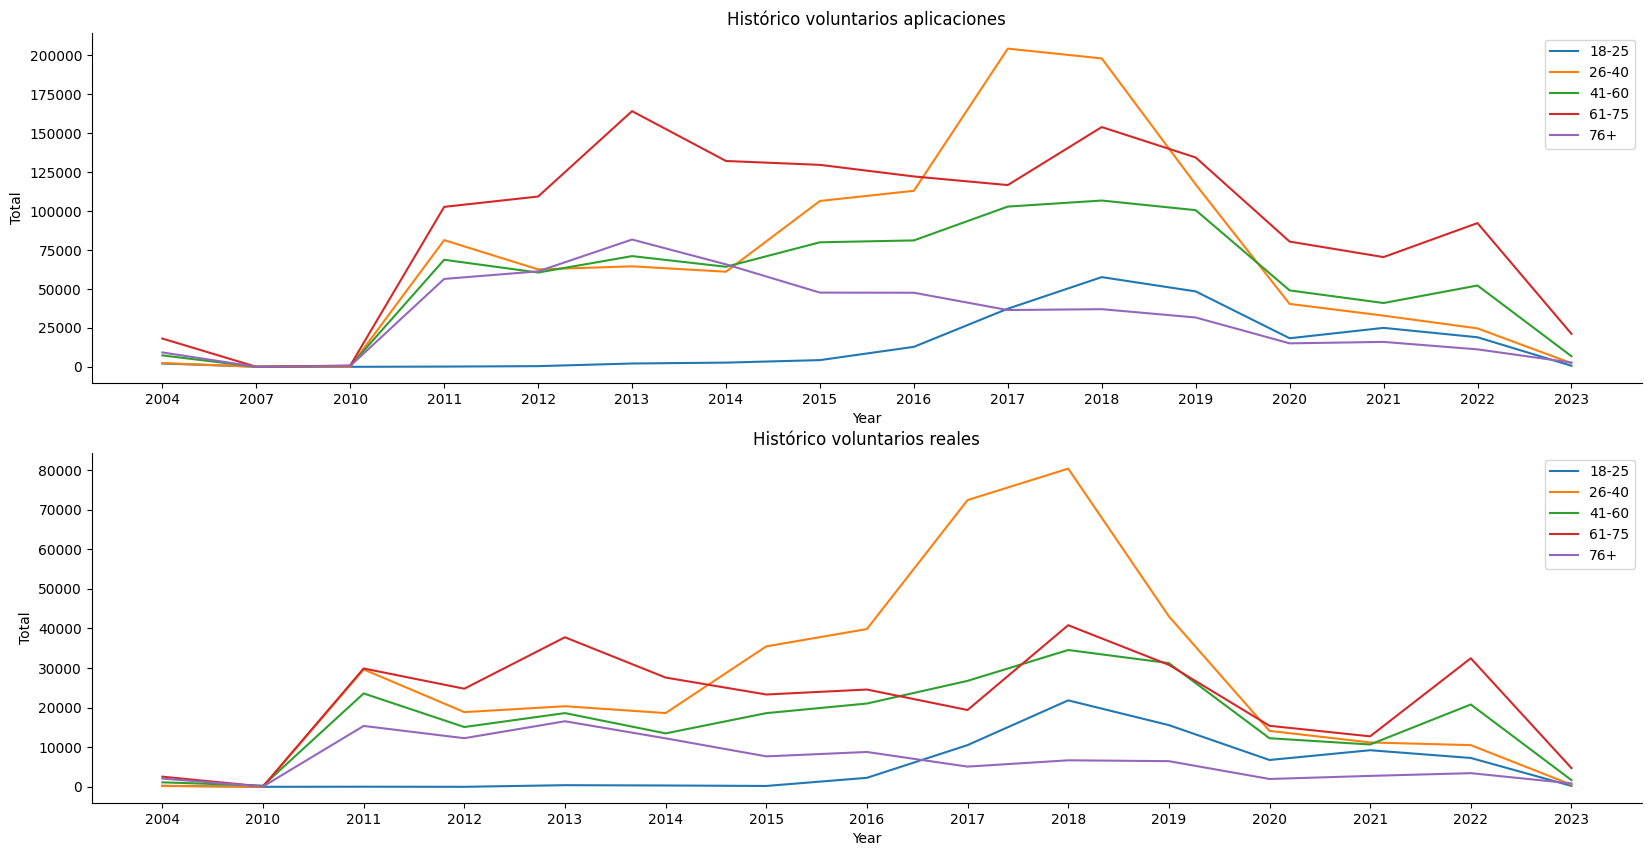

In [ ]:
sp.graf_historico1(timeline_age_totales,'Age_Group','Year','Total','Histórico voluntarios aplicaciones',timeline_age_real,'Age_Group','Year','Total','Histórico voluntarios reales')

In [ ]:
#Agrupamos los asistentes por nacionalidad
df_pais_asistente = pd.DataFrame(df_unicos.groupby(['Nationality'])
                      ["Year"].count()).reset_index()

df_pais_asistente.rename({'Year': 'Total'}, axis=1, inplace=True)

#calculamos el porcentaje de los paises
df_pais_asistente['Porcentaje']=sp.porcentaje(df_pais_asistente,'Total')

#nos quedamos con los que represntan más del 2% y al resto lo renombramos OTHERS
df_pais_asistente['Nationality_groups']=np.where(df_pais_asistente['Porcentaje']<2,'OTHERS',df_pais_asistente['Nationality'])

#volvemos a agrupar por nacionalidad
df_pais_asistente_grupo = pd.DataFrame(df_pais_asistente.groupby(['Nationality_groups'])
                      ['Porcentaje','Total'].sum()).reset_index()

#lo colocamos en orden
df_pais_asistente_grupo.sort_values(by='Porcentaje',ascending=False,inplace=True)
df_pais_asistente_grupo

,Nationality_groups,Porcentaje,Total
7,USA,44.02,11797
5,OTHERS,20.13,5426
6,UNITED KINGDOM,12.76,3419
1,CANADA,8.49,2275
2,INDIA,6.82,1828
0,AUSTRALIA,3.05,818
3,IRELAND,2.54,681
4,NIGERIA,2.07,556


In [ ]:
#Repetimos la operacion pero con el total de las aplicaciones, no solo los asistente
df_pais_totales = pd.DataFrame(df2.groupby(['Nationality'])
                      ["Year"].count()).reset_index()

df_pais_totales.rename({'Year': 'Total'}, axis=1, inplace=True)

df_pais_totales['Porcentaje']=sp.porcentaje(df_pais_totales,'Total')


df_pais_totales['Nationality_groups']=np.where(df_pais_totales['Porcentaje']<2,'OTHERS',df_pais_totales['Nationality'])

df_pais_totales_grupo = pd.DataFrame(df_pais_totales.groupby(['Nationality_groups'])
                      ['Porcentaje','Total'].sum()).reset_index()

df_pais_totales_grupo=df_pais_totales_grupo.sort_values(by='Porcentaje',ascending=False)
df_pais_totales_grupo

,Nationality_groups,Porcentaje,Total
6,USA,44.65,40348
4,OTHERS,17.86,16164
5,UNITED KINGDOM,16.65,15042
1,CANADA,9.21,8323
2,INDIA,5.40,4881
3,IRELAND,3.20,2896
0,AUSTRALIA,3.00,2712


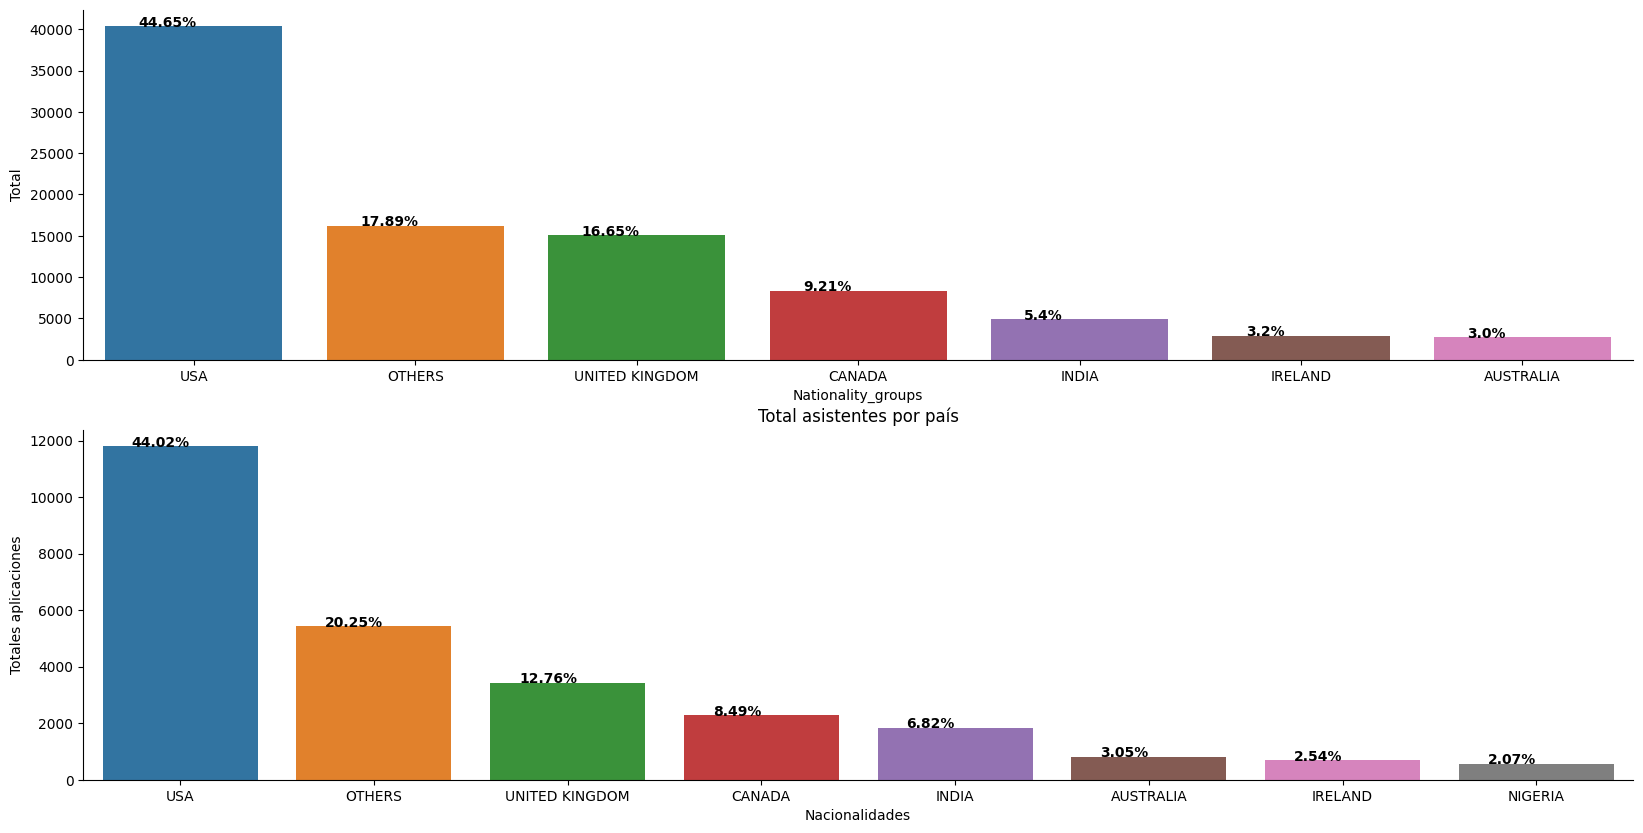

In [ ]:
sp.graf_barras1('Nationality_groups','Total',df_pais_totales_grupo,'Nacionalidades','Totales aplicaciones','Total aplicaciones por país','Total','Nationality_groups','Total',df_pais_asistente_grupo,'Nacionalidades','Totales aplicaciones','Total asistentes por país','Total')


In [ ]:
#Ya que OTHERS tiene un porcentaje tan alto, vamos a agruparlos al menos por continente, para ello vamos a separarlo en una dataframe diferente
df_nacionalidad_otros=df_pais_asistente[df_pais_asistente['Nationality_groups']=='OTHERS']
df_nacionalidad_otros.sort_values(by='Porcentaje',ascending=False)
df_nacionalidad_otros['Nationality']=df_nacionalidad_otros['Nationality'].str.title()

In [ ]:
#llamamos el csv que creamos con web scrapping
df_paises = pd.read_csv('datos/paises.csv')
df_paises= df_paises.drop(['M49_Code', 'Region1', 'Region2'], axis=1)
df_paises

,Country,ISO_Code,Continent
0,Afghanistan,AFG,Asia
1,Åland Islands,ALA,Europe
2,Albania,ALB,Europe
3,Algeria,DZA,Africa
4,American Samoa,ASM,Oceania
...,...,...,...
244,Wallis and Futuna Islands,WLF,Oceania
245,Western Sahara,ESH,Africa
246,Yemen,YEM,Asia
247,Zambia,ZMB,Africa


In [ ]:
df_paises.isnull().sum()

Country      0
ISO_Code     0
Continent    0
dtype: int64

In [ ]:
#Hacemos un merge por Nationality y sacamos los porcentajes
continentes = pd.merge(df_nacionalidad_otros, df_paises, left_on='Nationality', right_on='Country', how='inner')
continentes=continentes.drop(['Nationality_groups','Country'],axis=1)
continentes.sort_values(by='Porcentaje',ascending=False,inplace=True)
continentes

,Nationality,Total,Porcentaje,ISO_Code,Continent
91,Morocco,504,1.88,MAR,Africa
118,South Africa,333,1.24,ZAF,Africa
105,Philippines,305,1.14,PHL,Asia
2,Algeria,282,1.05,DZA,Africa
56,Ghana,269,1.00,GHA,Africa
...,...,...,...,...,...
5,Antarctica,1,0.00,ATA,Antarctica
8,Aruba,1,0.00,ABW,North America
117,Slovenia,1,0.00,SVN,Europe
57,Gibraltar,1,0.00,GIB,Europe


In [ ]:
continentes.isnull().sum()

Nationality    0
Total          0
Porcentaje     0
ISO_Code       0
Continent      0
dtype: int64

In [ ]:
#Agrupamos por continente y total y sacamos los porcentajes de los continentes
continente_group=continentes.groupby('Continent')['Total'].sum().reset_index()
continente_group['Porcentaje']=sp.porcentaje(continente_group,'Total')
continente_group=continente_group.sort_values(by='Porcentaje',ascending=False)
continente_group

,Continent,Total,Porcentaje
0,Africa,2319,46.28
2,Asia,1275,25.44
3,Europe,622,12.41
4,North America,371,7.40
5,Oceania,296,5.91
6,South America,127,2.53
1,Antarctica,1,0.02


In [ ]:
#Utilizamos geopy para buscar las coordenadas de las capitales de cada pais.
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="pepe")

#usamos una lambda para acceder a 'Nationality' y que nos encuentre las capitales de los paises y nos devuelva sus coordenadas
continentes['capital_coordinates'] = continentes['Nationality'].apply(lambda x: geolocator.geocode(x+', capital', timeout=10).point if geolocator.geocode(x+', capital', timeout=10) else None)

In [ ]:
continentes.head(2)

,Nationality,Total,Porcentaje,ISO_Code,Continent,capital_coordinates
91,Morocco,504,1.88,MAR,Africa,"31 32m 2.92092s S, 68 31m 23.079s W"
118,South Africa,333,1.24,ZAF,Africa,"33 58m 11.8391s S, 18 35m 42.256s E"


In [ ]:

continentes = continentes.dropna(subset=['capital_coordinates']).reset_index(drop=True)
continentes['capital_coordinates'].isnull().sum()

0

In [ ]:
continentes.to_csv("datos/continentes.csv",index=False, header=True)

In [ ]:

map = folium.Map()

def convert_coordinates(point):
    if point is None:
        return None
    return [point.latitude, point.longitude]

# Apply the function to the capital_coordinates column
continentes["capital_coordinates"] = continentes["capital_coordinates"].apply(convert_coordinates)

# Iterate over the dataframe and add marker
for index, row in continentes.iterrows():
    if any(pd.isna(x) for x in row['capital_coordinates']):
        continue
    marker = folium.Marker(location=row['capital_coordinates'], 
                           popup=f"Country: {row['Nationality']} <br> Percentage: {row['Porcentaje']}")
    marker.add_to(map)
map


In [ ]:
#vamos a ver los veretarnos por grupos de edades y cuantas veces vienen así que creamos un dataframe nuevo con el nombre y la edad
veteran_counts = df2.groupby(['Name','Age']).count()
veteran_counts=veteran_counts.reset_index()
veteran_counts=veteran_counts[['Name','Age', 'Year']]
veteran_counts.rename({'Year': 'Total'}, axis=1, inplace=True)
veteran_counts.sort_values(by= 'Total', ascending=False, inplace=True)
veteran_counts.head(2)


,Name,Age,Total
25338,Robert Moore,76.0,152
13773,Jessica Johnson,44.0,91


In [ ]:
bins_total = [0, 1, 2, 3, 6, 10, veteran_counts['Total'].max()]
labels_total = ['1', '2' ,'3','4-6','7-10', '+10']
veteran_counts['Veterans_Group'] = pd.cut(veteran_counts['Total'], bins=bins_total, labels=labels_total)

veteran_counts['Age_Group'] = pd.cut(veteran_counts['Age'], bins=bins_age, labels=labels_age)

veteran_counts.head(2)

,Name,Age,Total,Veterans_Group,Age_Group
25338,Robert Moore,76.0,152,+10,76+
13773,Jessica Johnson,44.0,91,+10,41-60


In [ ]:
veteran_group_by_age= veteran_counts.groupby(['Veterans_Group','Age_Group']).count().reset_index()
veteran_group_by_age['Porcentaje']= sp.porcentaje(veteran_group_by_age,'Total')
veteran_group_by_age=veteran_group_by_age[['Veterans_Group','Age_Group','Porcentaje']]
#veteran_group.sort_values(by='Porcentaje', ascending=False, inplace=True)"""
veteran_group_by_age.head(2)

,Veterans_Group,Age_Group,Porcentaje
0,1,18-25,0.74
1,1,26-40,3.22


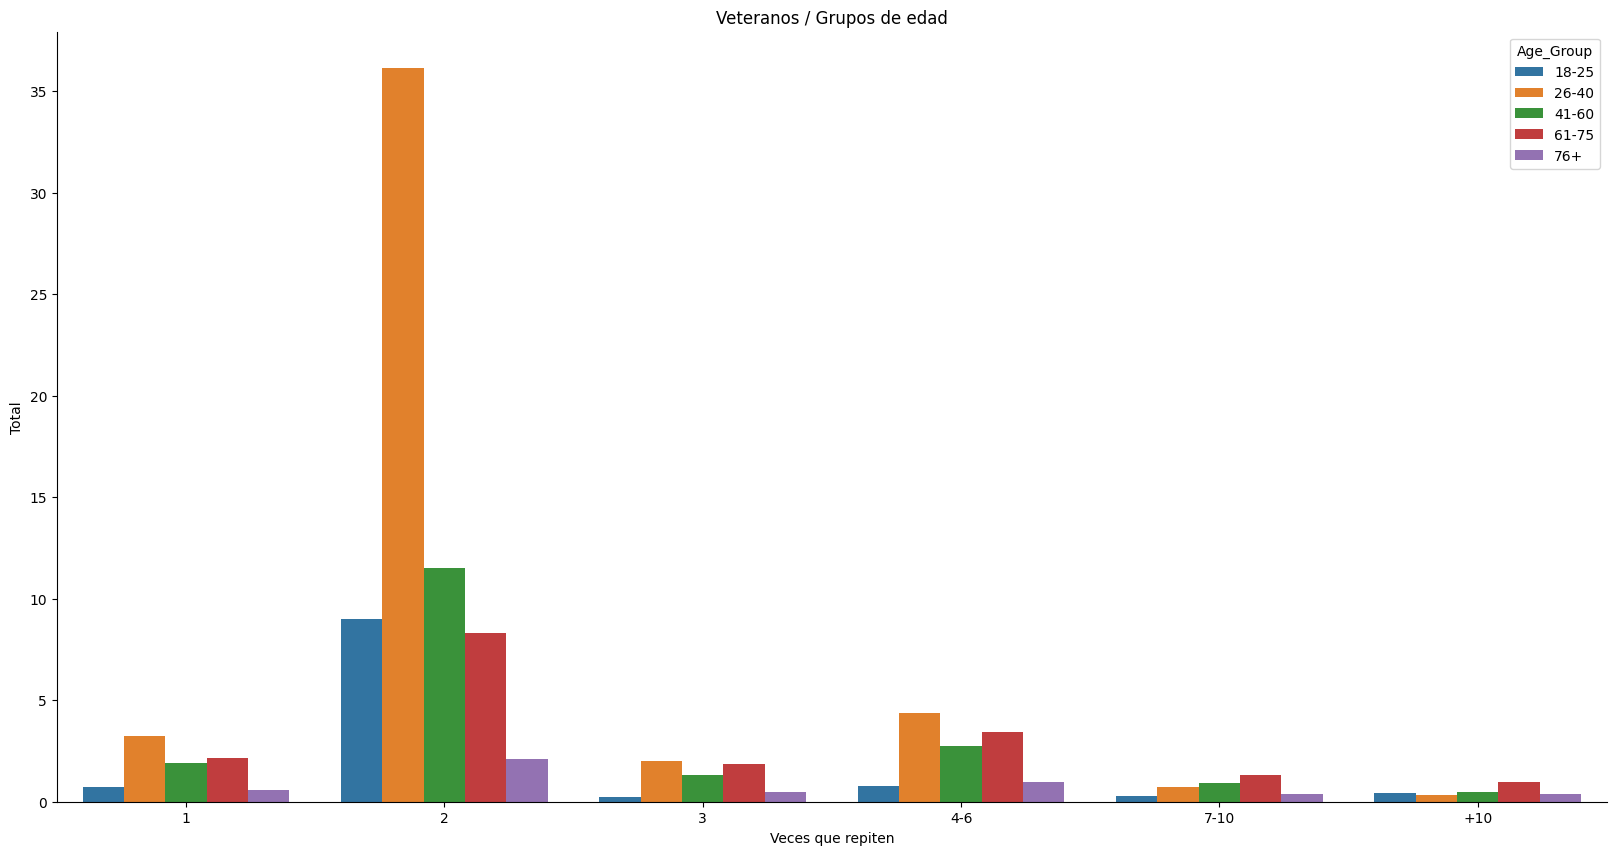

In [ ]:
sp.graf_barras2('Veterans_Group','Porcentaje','Age_Group',veteran_group_by_age,'Veces que repiten','Total','Veteranos / Grupos de edad')

In [ ]:
# Vamos a buscar los cursos Crear una expresión regular para buscar "TEENS" o "TEEN"
pattern = re.compile("TEENS|TEEN", re.IGNORECASE)

# Seleccionar las filas donde la columna "Course" contiene el patrón
cursos = df_arrivals[df_arrivals['Course'].str.contains(pattern)]
cursos=cursos['Course'].unique()

In [ ]:
cursos

array(['La Alberca TEENS-VOLUNTEER 2 WEEKS from 07/02/2021 to 07/16/2021',
       'La Alberca TEENS-VOLUNTEER 2 WEEKS from 07/09/2021 to 07/23/2021',
       'Valverde TEENS-VOLUNTEER 1 WEEK from 07/09/2021 to 07/16/2021',
       'La Alberca TEENS-VOLUNTEER 1 WEEK from 07/02/2021 to 07/09/2021',
       'La Alberca TEENS-VOLUNTEER 1 WEEK from 07/16/2021 to 07/23/2021',
       'La Alberca TEENS-VOLUNTEER 1 WEEK from 07/09/2021 to 07/16/2021'],
      dtype=object)

In [ ]:
cursos = pd.Series(cursos).reset_index(drop=True)
cursos=sp.dividir_serie(cursos)
cursos

,Destino,Tipo,Duración,Comienzo,Final,Nombre_completo
0,La Alberca,TEENS,2 WEEKS,07/02/2021,07/16/2021,La Alberca TEENS-VOLUNTEER 2 WEEKS from 07/02/...
1,La Alberca,TEENS,2 WEEKS,07/09/2021,07/23/2021,La Alberca TEENS-VOLUNTEER 2 WEEKS from 07/09/...
2,Valverde,TEENS,1 WEEK,07/09/2021,07/16/2021,Valverde TEENS-VOLUNTEER 1 WEEK from 07/09/202...
3,La Alberca,TEENS,1 WEEK,07/02/2021,07/09/2021,La Alberca TEENS-VOLUNTEER 1 WEEK from 07/02/2...
4,La Alberca,TEENS,1 WEEK,07/16/2021,07/23/2021,La Alberca TEENS-VOLUNTEER 1 WEEK from 07/16/2...
5,La Alberca,TEENS,1 WEEK,07/09/2021,07/16/2021,La Alberca TEENS-VOLUNTEER 1 WEEK from 07/09/2...


In [ ]:
cursos.to_csv("datos/cursos_teens.csv",index=False, header=True)

In [ ]:
df_arrivals=df_arrivals[['Course', 'Birth_Date', 'Gender','Nationality','Arrival_Medium','Arrival_Company','Arrival_Number','Name']]


In [ ]:
re.search("\d{2}/\d{2}/\d{4}",df_arrivals["Course"][90367] ).group()

'07/02/2021'

In [ ]:
df_arrivals["Comienzo"] = df_arrivals["Course"].apply(lambda x:re.search("\d{2}/\d{2}/\d{4}",x ).group())

In [ ]:
df_arrivals.dtypes

Course             object
Birth_Date         object
Gender             object
Nationality        object
Arrival_Medium     object
Arrival_Company    object
Arrival_Number     object
Name               object
Comienzo           object
Llegada            object
dtype: object

In [ ]:
df_arrivals['Llegadas']=df_arrivals['Comienzo'].astype(datetime)

TypeError: dtype '<class 'datetime.datetime'>' not understood

In [ ]:
df_arrivals.to_csv("datos/arrivals.csv",index=False, header=True)